# Introduction : Création d'une grille pseudo-rectangulaire simple munie de parallèlogrammes avec le module XUarray pour Python

### Importation des packages nécéssaires

In [24]:
import matplotlib.pyplot as plt
import xarray as xr
import xugrid as xu
import numpy as np

### Paramètres physiques pour une simple grille rectagulaire nx par ny

In [25]:
nx = 15
ny = 10

### Création du mapping entre les noeuds de grille et leur position (x,y)

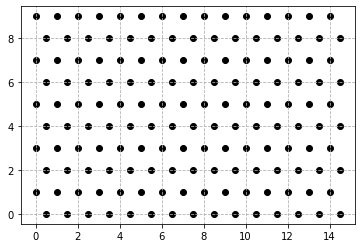

In [26]:
# Mapping : Dictionnaire "maps" est un dictionnaire permettant d'accéder à # du noeud pour à
# chaque positions définit par le tuple (jy,ix)
maps = {}
k = 0
for jy in np.linspace(0,ny-1,ny) :
    for ix in np.linspace(0,nx-1,nx) :
        if jy%2 == 0 : 
            maps[(jy,ix+0.5)] = k
            k += 1
        else : 
            maps[(jy,ix)] = k
            k += 1
            
# Création d'une figure pour illustrer :
x_positions = [item[1] for item in maps.keys()]
y_positions = [item[0] for item in maps.keys()]
plt.scatter(x_positions, y_positions,color = 'black')
plt.grid(linestyle='dashed')
plt.show()

### Dépendance entre les faces et les noeuds de grille, i.e. la topologie de la grille

In [27]:
# Topologie
facestonode = []
for jy in np.linspace(0,ny-2,ny-1) : 
    for ix in np.linspace(0,nx-2,nx-1) :
        if jy%2 == 0 : 
            facestonode += [ [maps[(jy,ix+0.5)],
                              maps[(jy,ix+1.5)],
                              maps[(jy+1,ix+1)],
                              maps[(jy+1,ix)]]]
        else : 
            facestonode += [ [maps[(jy,ix)],
                              maps[(jy,ix+1)],
                              maps[(jy+1,ix+1.5)],
                              maps[(jy+1,ix+0.5)]]]
        
# Le numpy.array "facestonode" contient ainsi 4 noeuds pour chaque faces : 
facestonode = np.array(facestonode)

# Le fameux numpy.array contenant les connections : 
facestonode

array([[  0,   1,  16,  15],
       [  1,   2,  17,  16],
       [  2,   3,  18,  17],
       [  3,   4,  19,  18],
       [  4,   5,  20,  19],
       [  5,   6,  21,  20],
       [  6,   7,  22,  21],
       [  7,   8,  23,  22],
       [  8,   9,  24,  23],
       [  9,  10,  25,  24],
       [ 10,  11,  26,  25],
       [ 11,  12,  27,  26],
       [ 12,  13,  28,  27],
       [ 13,  14,  29,  28],
       [ 15,  16,  31,  30],
       [ 16,  17,  32,  31],
       [ 17,  18,  33,  32],
       [ 18,  19,  34,  33],
       [ 19,  20,  35,  34],
       [ 20,  21,  36,  35],
       [ 21,  22,  37,  36],
       [ 22,  23,  38,  37],
       [ 23,  24,  39,  38],
       [ 24,  25,  40,  39],
       [ 25,  26,  41,  40],
       [ 26,  27,  42,  41],
       [ 27,  28,  43,  42],
       [ 28,  29,  44,  43],
       [ 30,  31,  46,  45],
       [ 31,  32,  47,  46],
       [ 32,  33,  48,  47],
       [ 33,  34,  49,  48],
       [ 34,  35,  50,  49],
       [ 35,  36,  51,  50],
       [ 36,  

### Création d'un Xarray Dataset contenant tous les informations nécessaires

In [28]:
# On crée 3 numpy.array, une pour la position des noeuds en x, en y et une 
# pour la température, qui sera notre variable à l'étude.
x = []
y = []
Temperature = []
for keys in maps : 
    ix,jy = keys
    x += [ix]
    y += [jy]
    temp = 2*ix + 0.5*jy
    Temperature += [temp]
    
x = np.array(x)
y = np.array(y)
Temperature = np.array(Temperature)

temp_face = np.random.rand(nx-1,ny-1).flatten()

# Création d'un Xarray Dataset
ds = xr.Dataset({'temperature':(['node'],Temperature),
                 'temp_face':(['face'],temp_face),
                 'latitude':(['node'],x),
                 'longitude':(['node'],y),
                 'face_node_connectivity':(['face','nmax_face'],facestonode),
                 'mesh2d':([''],[])})

# On écrit les attribus généraux de notre grille pour la "face node connectivity"
ds.face_node_connectivity.attrs = {'cf_role': 'face_node_connectivity',
                                   'long_name': 'Vertex nodes of mesh faces (counterclockwise)',
                                   'start_index': 0}

# mesh2d est simplement une liste vide qui contient les attributs pour décrire notre grille.
ds.mesh2d.attrs = {'cf_role': 'mesh_topology',
                   'long_name': 'Topology data of 2D mesh',
                   'topology_dimension': 2,
                   'node_coordinates': 'longitude latitude',
                   'face_node_connectivity': 'face_node_connectivity',
                   'edge_node_connectivity': 'edge_node_connectivity'}

# Le xarray.dataset :

Toute l'information sur la création d'un Xarray Dataset permettant d'être transformée en grille par la transformation XUgrid peut se retrouver dans la documentation suivante : https://deltares.github.io/xugrid/examples/quick_overview.html . Les créateurs du module XUgrid sont les mêmes qui ont travaillé sur le modèle Delft3D.

### On peut maintenant transformer notre Xarray.Dataset en UXarray.UgridDataset

Le module XUgrid s'occupe lui même de faire les connections et trouver les faces et les noeuds de notre grille.

In [29]:
uds = xu.UgridDataset(ds)
uds

### On représente notre grille associée à la variable "temp", soit la température.

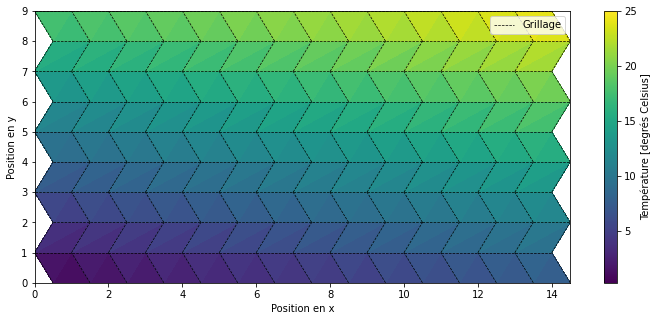

In [30]:
temp = uds['temperature']
temp.ugrid.plot(cmap='viridis', figsize=(12, 5), cbar_kwargs = {'label':"Température [degrés Celsius]"})
temp.ugrid.plot.line(color = 'black', linewidth = 0.7, linestyle = 'dashed', label = 'Grillage')
plt.legend()
plt.ylabel('Position en y')
plt.xlabel('Position en x')
plt.show()

### Pour observer la variable "temp" associées à la température :

### Maintenant, on test les faces des neouds : 

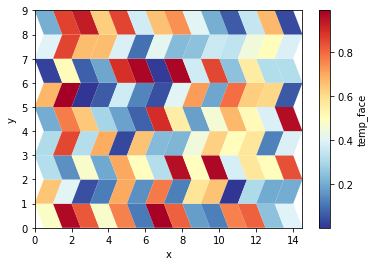

In [36]:
uds['temp_face'].ugrid.plot(cmap = 'RdYlBu_r')
